In [1]:
'''
By Chance

Loads and processes ATL11 data

Input: .ini config file which fills all variables in preamble

Output: a bunch of figures
	Map of dh/dt
	Map of elevation
	Ensemble Median Anomaly
	Ensemble Relative Elevation Count
	Ensemble dh/dt distribution
	Ensemble Median Elevations


'''

# System libraries
import os
import sys
import h5py
import configparser

#Standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio as rs

#For geometries
from shapely import box, LineString, Point, Polygon
from shapely.geometry.polygon import orient

#For REMA
from rasterio import plot
from rasterio.mask import mask
from rasterio.features import rasterize

#Datetime
from datetime import datetime
from datetime import timezone
import time

#For plotting, ticking, and line collection
from matplotlib import cm 
import matplotlib.pylab as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
import earthpy.spatial as es

#Personal and application specific utilities
from utils.nsidc import download_is2
#from utils.S2 import plotS2cloudfree, add_inset, convert_time_to_string
from utils.utilities import is2dt2str

#For error handling
import traceback



In [2]:


ini = 'config/Cp-D_all_lumos.ini'

######## Load variables ###########
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the configuration file
config.read(ini)

#os and pyproj paths
gdal_data = config.get('os', 'gdal_data')
proj_lib = config.get('os', 'proj_lib')
proj_data = config.get('os', 'proj_data')

#path params
basin = config.get('data', 'basin')
region = config.get('data', 'region')
shape = f'shapes/{basin}_{region}.shp'
output_dir = config.get('data', 'output_dir')
rema_path = config.get('data', 'rema_path')
try: fig_dir = config.get('data', 'fig_dir')
except: fig_dir='figs'

#access params
uid = config.get('access', 'uid')
pwd = config.get('access', 'pwd')
email = config.get('access', 'email')

#Print results
os.environ["GDAL_DATA"] = gdal_data # need to specify to make gdal work
os.environ["PROJ_LIB"] = proj_lib # need to specify to make pyproj work
os.environ["PROJ_DATA"] = proj_data # need to specify to make pyproj work

print(f"basin: {basin}")
print(f"region: {region}")
print(f"output_dir: {output_dir}")

print(f"uid: {uid}")
print(f"pwd: {'*'*len(pwd)}")
print(f"email: {email}")




basin: Cp-D
region: all
output_dir: /Volumes/nox2/Chance/data/is2/ATL11_Cp-D_all
uid: ccroberts
pwd: **********
email: ccroberts@ucsd.edu


In [3]:

########### Code ####################
crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'
short_name = 'ATL11'
# Read shapefile into gdf for everything
gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)

# Separate by entry type
gdf_fl = gdf[gdf.Id_text=='Ice shelf']
gdf_pp = gdf[(gdf.Id_text=='Ice rise or connected island')]
gdf_ext = gpd.GeoDataFrame(geometry=[gdf_fl.apply(lambda p: Polygon(p.geometry.exterior.coords), axis=1).unary_union.union(gdf_pp.unary_union)],
    crs=crs_antarctica).explode(ignore_index=True)
gdf_gr = gdf[gdf.Id==1]
gdf_ext_all = gpd.GeoDataFrame(geometry=[gdf_ext.unary_union.union(gdf_gr.unary_union)], crs=crs_antarctica)

# gdf for subsetting
#gdf = gdf[~(gdf.Id==1)]
gdf = gpd.GeoDataFrame(geometry=[gdf.unary_union], crs=crs_antarctica)

### Define a bunch of functions (folded)
def download_data():
    uid,pw,eml = getedcreds()
    download_is2(short_name='ATL11', uid=uid, pwd=pw, email=eml, output_dir=output_dir, shape=shape, shape_subset=shape)
    print('saved files to %s' % output_dir)
    return output_dir

def get_file_info():
    search_for = '%s_' % short_name
    search_in = output_dir + '/'
    filelist = [search_in+f for f in os.listdir(search_in) \
                if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
    filelist.sort()
    print('There are %i files.' % len(filelist))
    
    dirdict = dict([(x,'ascending') for x in [1,2,3,12,13,14]] + \
                   [(x,'descending') for x in [5,6,7,8,9,10]] + \
                   [(x,'turning') for x in [4,11]])
    df_files = pd.DataFrame({'filename': filelist})
    df_files['granule_id'] = df_files.apply(lambda x: x.filename[x.filename.rfind(search_for):], axis=1)
    df_files['tides_filename'] = df_files.apply(lambda x: f'{output_dir}/tides/ATL11_CATS2008-v2023_TIDES_{x.granule_id[6:]}', axis=1)
    df_files['track'] = df_files.apply(lambda x: int(x.granule_id[6:10]), axis=1)
    df_files['region'] = df_files.apply(lambda x: int(x.granule_id[10:12]), axis=1)
    df_files['direction'] = df_files.apply(lambda x: dirdict[x.region], axis=1)
    df_files['cycles'] = df_files.apply(lambda x: '%s-%s' % (x.granule_id[13:15],x.granule_id[15:17]), axis=1)
    df_files['version'] = df_files.apply(lambda x: int(x.granule_id[18:21]), axis=1)
    df_files['release'] = df_files.apply(lambda x: int(x.granule_id[22:24]), axis=1)
    return df_files

def getedcreds():
    # change your credentials here, do not push them to github! 
    uid = uid
    pwd = pwd
    email = email

    # to print a message if they haven't been changed
    if uid == '<your_nasa_earthdata_user_id>':
        print('\n WARNING: YOU NEED TO SET UP YOUR NASA EARTHDATA CREDENTIALS TO DOWNLOAD ICESAT-2 DATA!\n')
        print('  update the info in ed/edcreds.py :\n')
        print("  def getedcreds():")
        print("    # change your credentials here, do not push them to github!")
        print("    uid = '<your_nasa_earthdata_user_id>'")
        print("    pwd = '<your_nasa_earthdata_password>'")
        print("    email = '<your_nasa_earthdata_account_email>'")
        return None
    else:
        return uid, pwd, email

def is2dt2str(lake_mean_delta_time):
    lake_mean_delta_time = np.mean(lake_mean_delta_time)
    if np.isnan(lake_mean_delta_time) | (lake_mean_delta_time == np.inf):
        return np.nan
    else:
        ATLAS_SDP_epoch_datetime = datetime(2018, 1, 1, tzinfo=timezone.utc)
        ATLAS_SDP_epoch_timestamp = datetime.timestamp(ATLAS_SDP_epoch_datetime)
        lake_mean_timestamp = ATLAS_SDP_epoch_timestamp + lake_mean_delta_time
        lake_mean_datetime = datetime.fromtimestamp(lake_mean_timestamp, tz=timezone.utc)
        time_format_out = '%Y-%m-%dT%H:%M:%SZ'
        is2time = datetime.strftime(lake_mean_datetime, time_format_out)
        return is2time

def set_axis_color(ax, axcolor):
    ax.spines['bottom'].set_color(axcolor)
    ax.spines['top'].set_color(axcolor) 
    ax.spines['right'].set_color(axcolor)
    ax.spines['left'].set_color(axcolor)
    ax.tick_params(axis='x', colors=axcolor)
    ax.tick_params(axis='y', colors=axcolor)
    ax.yaxis.label.set_color(axcolor)
    ax.xaxis.label.set_color(axcolor)
    ax.title.set_color(axcolor)

def get_ground_tracks(datadict):
    crs_latlon = 'EPSG:4326'
    gts = []
    for k in datadict.keys():
        ds = datadict[k]
        gdf_gt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.longitude, ds.latitude), crs=crs_latlon)
        #for 3d geometry
        #gdf_gt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(ds.longitude, ds.latitude, ds.h_ano.sel(track=ds.track.data[0], pt=k).mean(dim='cycle_number')), crs=crs_latlon)
        gdf_gt['pt'] = k
        gts.append(gdf_gt)
    gdf_gts = gpd.GeoDataFrame(geometry=pd.concat(gts).groupby(['pt'])[['geometry']].apply(lambda x: LineString(x.geometry.tolist()))
        ).reset_index().set_crs(crs_latlon)
    colordict = {'col0': 'darkblue', 'col1': 'rebeccapurple', 'col2': 'palevioletred', 'col3': 'thistle'}
    gdf_gts['figcolor'] = gdf_gts.apply(lambda x: colordict['col%s' % (int(x.pt[2])-1)], axis=1)
    gdf_gts['track'] = ds.track.data[0]
    
    return gdf_gts

def read_atl11(filename, track, verbose=False):
    if verbose: print(f'reading track: {track}')
    with h5py.File(filename, 'r') as f:
        datadict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            try:
                vars_data = ['delta_time', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'quality_summary']
                vars_coords = ['cycle_number', 'latitude', 'longitude','ref_pt']
                ds = xr.Dataset({**{v: (['x', 'cycle_number', 'track', 'pt'], f[pt][v][()][:, :, np.newaxis, np.newaxis]) for v in vars_data},
                    'geoid': (['x', 'track', 'pt'], f[pt]['ref_surf/geoid_h'][()][:, np.newaxis, np.newaxis])},
                    coords={'cycle_number': f[pt]['cycle_number'][()],
                    **{v : ('x', f[pt][v][()]) for v in vars_coords[1:]}})
                ds.coords['x'], ds['track'], ds['pt'] = np.arange(len(ds.x)), [track], [pt]
                ds = ds.assign_coords(x_atc=('x', np.arange(len(f[pt]['latitude'][()])) * 60))
                h_arr = np.array(ds.h_corr-ds.geoid)# go to numpy for 2-d boolean indexing
                h_arr[ds.quality_summary>0] = np.nan
                h_arr[(h_arr>3e2)+(h_arr<-50)] = np.nan
                ds['h_corr'] = (ds.h_corr.dims, h_arr)
                ds['h_corr'] = ds.h_corr+ds.geoid
                datadict[pt] = ds
            #except KeyError as e:
            #    print(f"KeyError: The key {e} was not found in the data source.")
            #except ValueError as e:
            #    print(f"ValueError: {e}")
            #except Exception as e:
            #    print(f"An unexpected error occurred: {e}")
            except: continue
    return datadict

def read_atl11_tides(filename, track):
    with h5py.File(filename, 'r') as f:
        tidedict = {}
        pts = [x for x in f.keys() if 'pt' in x]
        for pt in pts:
            vars_data = ['delta_time', 'cycle_stats/tide_ocean']
            vars_coords = ['cycle_number', 'latitude', 'longitude', 'ref_pt']
            ds = xr.Dataset({v: (['x', 'cycle_number', 'track', 'pt'], f[pt][v][()][:, :, np.newaxis, np.newaxis]) for v in vars_data}, 
                    coords={'cycle_number': f[pt]['cycle_number'][()],
                    **{v : ('x', f[pt][v][()]) for v in vars_coords[1:]}})
            ds.coords['x'], ds['track'], ds['pt'] = np.arange(len(ds.x)), [track], [pt]
            ds = ds.assign_coords(x_atc=('x', np.arange(len(f[pt]['latitude'][()])) * 60))
            ds = ds.rename({'cycle_stats/tide_ocean': 'tide_cats'})
            tide_cats = np.array(ds.tide_cats) # go to numpy for 2-d boolean indexing
            tide_cats[tide_cats>1e5]=np.nan
            ds['tide_cats'] = (ds.tide_cats.dims, tide_cats)
            #ds['tide_cats'] = ds.tide_cats.interpolate_na(dim='x', method='linear').interpolate_na(dim='x', method='nearest', fill_value='extrapolate')
            tidedict[pt] = ds
    return tidedict

def get_data(track, verbose=False):
    # get the data
    filename = df_files[df_files.track == track].filename.iloc[0]
    tides_filename = df_files[df_files.track == track].tides_filename.iloc[0]
    datadict = read_atl11(filename, track, verbose)
    tidedict = read_atl11_tides(tides_filename, track)
    datadict = {pt: xr.merge([datadict[pt], tidedict[pt]], join='inner', compat='override') for pt in datadict}
    datadict = {pt: datadict[pt].assign(h_abs=(('x', 'cycle_number', 'track', 'pt'), 
        (datadict[pt]['h_corr']-datadict[pt]['geoid']-datadict[pt]['tide_cats']).data)) for pt in datadict}
    datadict = {pt: datadict[pt].assign(h_ano=(('x', 'cycle_number', 'track', 'pt'),
        (datadict[pt].h_abs-datadict[pt].h_abs.median(dim='cycle_number')).data)) for pt in datadict}
    gdf_gts = get_ground_tracks(datadict).to_crs(crs_antarctica)
    return datadict, gdf_gts

'''
def clip_data(datadict, gdf_gts, mask):
    #clip through rectangle is faster
    datadict_clipped = {}
    gdf_gts_clipped_list = []
    for pt in datadict:
        ds=datadict[pt]
        #select pt
        gdf_this = gdf_gts[gdf_gts.pt==pt]
        #convert linestring to points
        gdf_this_pts = gpd.GeoDataFrame(geometry=gdf_gts[gdf_gts.pt==pt].get_coordinates(ignore_index=True).apply(lambda l: Point(l), axis=1), 
            crs=crs_antarctica)
        gdf_clipped = gdf_this_pts.clip(mask.clip(gdf_this.bounds.values[0]))
        try: gdf_gts_clipped_list.append(gdf_this.clip(mask))
        except: continue
        datadict_clipped[pt] = ds.sel(x=(gdf_clipped.index))
    return datadict_clipped, pd.concat(gdf_gts_clipped_list, ignore_index=True)
'''

def clip_data(datadict, gdf_gts, mask):
    #clip through rectangle is faster
    datadict_clipped = {}
    gdf_gts_clipped_list = []
    for pt in datadict:
        ds=datadict[pt]
        #select pt
        gt_this = gdf_gts[gdf_gts.pt==pt]
        #convert linestring to points
        gt_this_pts = gpd.GeoDataFrame(geometry=gt_this.get_coordinates(ignore_index=True).apply(lambda l: Point(l), axis=1), 
            crs=crs_antarctica)
        gdf_clipped_index = gt_this_pts.clip(mask.clip(gt_this.bounds.values[0])).index
        try: gdf_gts_clipped_list.append(gt_this.clip(mask))
        except: continue
        datadict_clipped[pt] = ds.sel(x=(gdf_clipped_index))
    return datadict_clipped, pd.concat(gdf_gts_clipped_list, ignore_index=True)

def get_ds_dict(tracklist, mask=None):
    ds_list, gdf_gts_clipped_list = [], []
    for t in tracklist: 
        datadict, gdf_gts_clipped = get_data(t)
        if mask is not None: datadict, gdf_gts_clipped = clip_data(datadict, gdf_gts_clipped, mask)
        ds_add = xr.concat([datadict[pt] for pt in datadict], dim='pt')
        ds_add['x'] = np.arange(len(ds_add.x))
        ds_list.append(ds_add.sortby('x'))
        gdf_gts_clipped_list.append(gdf_gts_clipped)
    print('generating dict and gdf')
    return {ds.track.values[0]: ds for ds in ds_list}, pd.concat(gdf_gts_clipped_list, ignore_index=True)

def combine_ds_dict(ds_dict):
    ds_list = []
    for t in ds_dict:
        ds = ds_dict[t]
        if len(ds.x)!=0: 
            ds['x'] = np.arange(len(ds.x))
            ds_list.append(ds)
    return xr.concat(ds_list, dim='track')

def get_stats(tracklist, mask=None):
    ds_list = []
    gdf_gts_list = []
    for t in tracklist:
        datadict, gdf_gts_clipped = get_data(t)
        # subset here
        if mask is not None: datadict, gdf_gts_clipped = clip_data(datadict, gdf_gts_clipped, mask)
        gdf_gts_list.append(gdf_gts_clipped)
        for pt in datadict:
            try:
                ds = datadict[pt]
                h_abs = ds.h_corr - ds.geoid - ds.tide_cats
                coords_dict = {'cycle_number': ds.cycle_number.data,
                 'track': ds.track.data,
                 'pt': ds.pt.data}
                stat_dict = {'h_min': h_abs.min(dim='x'), 
                 'h_max': h_abs.max(dim='x'), 
                 'h_sum': h_abs.sum(dim='x'),
                 'h_mean': h_abs.mean(dim='x'), 
                 'h_med': h_abs.median(dim='x'), 
                 'h_ano': ds.h_ano.median(dim='x'),
                 'h_std': h_abs.std(dim='x', skipna=True, ddof=1),
                 'h_var': h_abs.var(dim='x', skipna=True, ddof=1), 
                 't_count': h_abs.count(dim='x'), 
                 'pct_nan': h_abs.count(dim='x')/h_abs.sizes['x'], 
                 't_dist': h_abs.count(dim='x')*0+h_abs.x_atc.max()/1000,
                 'tide_min': ds.tide_cats.min(dim='x'),
                 'tide_max': ds.tide_cats.max(dim='x'),
                 'tide_mean': ds.tide_cats.mean(dim='x'),
                 'tide_sum': ds.tide_cats.sum(dim='x')}
                dss = xr.Dataset({v: (['cycle_number', 'track', 'pt'], stat_dict[v].data) for v in stat_dict}, coords={v: coords_dict[v] for v in coords_dict})
                ds_list.append(dss)
            except: 
                continue
            #except KeyError as e:
            #    print(f'failed for track {t}, {pt}')
            #    print(f"KeyError: The key {e} was not found in the data source.")
            #except ValueError as e:
            #    print(f'failed for track {t}, {pt}')
            #    print(f"ValueError: {e}")
            #except Exception as e:
            #    print(f'failed for track {t}, {pt}')
            #    print(f"An unexpected error occurred: {e}")
    return xr.combine_by_coords(data_objects=ds_list), pd.concat(gdf_gts_list, ignore_index=True)
        
def reproject_raster(src, target_crs):
    '''
    Change crs of imported data
    '''
    
    src_crs = src.crs
    src_transform = src.transform
    src_width = src.width
    src_height = src.height

    # Define the target CRS
    target_crs = target_crs

    # Reproject the raster data to the target CRS
    reprojected_data, dst_transform = rs.warp.reproject(
        source=rs.band(src, 1),
        src_transform=src_transform,
        src_crs=src_crs,
        dst_crs=target_crs,
        resampling=rs.enums.Resampling.nearest)
    
    return reprojected_data, dst_transform, target_crs

def retry(num_attempts=1, sleep_time=5):
    for i in range(num_attempts): 
        try: 
            download_data()
            print(f'success on attempt {i}')
            return
        except Exception as e:
            if i==num_attempts-1:
                print(f"The following error occurred: {e}")
                traceback.print_exc()
            time.sleep(sleep_time)
    return


In [4]:

####

## load data

# Get_ds_dict, pretty fast
df_files=get_file_info()
#print('Loading data')
tracklist=df_files.track
#print('Generating data dicts')
#ds_dict, gdf_gts_all = get_ds_dict(tracklist, gdf_ext)
#ds_dict_fl, gdf_gts_fl = get_ds_dict(tracklist, gdf_fl)
#ds_dict_pp, gdf_gts_pp = get_ds_dict(tracklist, gdf_pp)

# Combine for full dataset
#print('Combining into xarray datasets')
#ds_all = combine_ds_dict(ds_dict)
#ds_fl = combine_ds_dict(ds_dict_fl)
#ds_pp = combine_ds_dict(ds_dict_pp)

processed_dir='/Volumes/nox2/Chance/processed_data/'
print('Reading netCDFs into XR datasets...', end='', flush=True)
ds_all = xr.open_dataset(f'{processed_dir}/{basin}_ds_all.nc')
ds_gr = xr.open_dataset(f'{processed_dir}/{basin}_ds_gr.nc')
ds_fl = xr.open_dataset(f'{processed_dir}/{basin}_ds_fl.nc')
ds_pp = xr.open_dataset(f'{processed_dir}/{basin}_ds_pp.nc')
print('DONE')

print('Reading ESRI shapefiles into geodataframes...', end='', flush=True)
gdf_gts_all = gpd.read_file(f'{processed_dir}/{basin}_gdf_gts_all.shp', engine='pyogrio')
gdf_gts_gr = gpd.read_file(f'{processed_dir}/{basin}_gdf_gts_gr.shp', engine='pyogrio')
gdf_gts_fl = gpd.read_file(f'{processed_dir}/{basin}_gdf_gts_fl.shp', engine='pyogrio')
gdf_gts_pp = gpd.read_file(f'{processed_dir}/{basin}_gdf_gts_pp.shp', engine='pyogrio')
print('DONE')




There are 322 files.
Reading netCDFs into XR datasets...DONE
Reading ESRI shapefiles into geodataframes...DONE


In [ ]:

# plot functions

## make plot function
def make_map(h_plot=None, dpi=600, rolling=None, vlims=[-5, 5], plot_rema=False, save=False, transparent=True):
    
    # figure setup
    major_font_size = 12
    minor_font_size = 10
    line_w = 0.5
    
    # make figure and axes
    fig, ax = plt.subplots(figsize=[13,8], dpi=dpi)
    
    # plot the basemap and ground tracks

    if plot_rema:
        with rs.open(rema_path) as src:
            dem = src.read()
            tr = src.transform
            bbox = box(*gdf_ext_all.total_bounds)
            src_masked, src_masked_tr = mask(src, shapes=[gdf_ext_all.geometry[0]], 
                crop=True, filled=False)
            src_hs = np.ma.masked_array(es.hillshade(src_masked[0].filled(np.nan)), mask=src_masked.mask[0])
            plot.show(src_hs, ax=ax, transform=src_masked_tr, cmap='Greys_r', 
                aspect='equal', vmin=-150, vmax=100)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_axis_off()
    
    #add ground tracks
    lc_list=[]
    if h_plot is not None:
        for i in range(len(gdf_gts_all)):
            row = gdf_gts_all[i:i+1]
            coords = row.get_coordinates()
            cmap = cmc.vik_r
            t = row.track.iloc[0]
            pt = row.pt.iloc[0]
            # Prepare segments for LineCollection
            # Prepare segments for LineCollection
            dc_dx = np.gradient(coords.x)
            dc_dx_idx = np.abs(dc_dx)>1e2
            coords.loc[dc_dx_idx, 'x'] = np.nan
            points = np.array([coords.x, coords.y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            # Create a LineCollection
            lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(vlims[0], vlims[1]))
            if rolling is not None: 
                try: 
                    h_plot = np.array(pd.Series(h_plot.sel(track=t, pt=pt)).rolling(window=rolling, center=True, min_periods=1, 
                    win_type='gaussian').mean(std=rolling/3))
                    print('succesfful')
                except: continue
            else: h_plot = h_plot.sel(track=t, pt=pt)
            lc.set_array(h_plot)
            lc.set_linewidth(line_w)
            lc_list.append(lc)
            ax.add_collection(lc)
    elif h_plot is None:
        gdf_gts_all.plot(ax=ax, color=gdf_gts_all.plotcolor, linewidth=line_w)
        gdf_gts_pp.plot(ax=ax, color='lightblue', linewidth=line_w)
    
    hdls = []
    gdf_ext_all.apply(lambda p: p.buffer(4e3)).plot(ax=ax, color='None', edgecolor='white', label='grounded ice', linewidth=1, zorder=500)
    gdf_pp.plot(ax=ax, color='None', edgecolor='black', label='grounded ice', linewidth=0.2, zorder=501)
    gdf_ext.apply(lambda p: p.buffer(1e3)).plot(ax=ax, color='None', edgecolor='royalblue', label='floating ice', linewidth=0.4, zorder=502)
    

    cfig, cax = plt.subplots(figsize=[4, 0.25])
    #cax.axis('off')
    #ax.text(0.5, 0.96, f'ICESat-2 ATL11 Height Change\n Basin {basin} 2019-2024', transform=ax.transAxes, 
    #        ha='center', va='center', fontsize=major_font_size, bbox=boxprops, zorder=502)
    # Create a ScalarMappable with the same colormap and normalization
    norm = mcolors.Normalize(vmin=vlims[0], vmax=vlims[1])
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    
    # Add the inset axis
    #pos = ax.get_position()
    #cax_pos = [pos.x0+pos.width*0.7, pos.y0+0.13, pos.width*0.25, pos.height*0.01]
    #cax_pos = [0, 0, 4, 0.5]
    #cax = fig.add_axes(cax_pos)
    #fig.patches.append(Rectangle((cax_pos[0]-, cax_pos[1]), cax_pos[2]*1.25, cax_pos[3]*2,
    #    transform=fig.transFigure, color='white', zorder=1))
    
    # Add a colorbar to the fig, with a specific location
    cbar = cfig.colorbar(sm, cax=cax, orientation='horizontal', fraction=0.1, pad=0.0)
    cbar.ax.tick_params(labelsize=minor_font_size) 
    cbar.set_label('ICESat-2 height change \n 2018-2024 (m yr$^{-1}$)', fontsize=minor_font_size)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(0.5)
    set_axis_color(cax, 'black')
    
    # Customize the colorbar ticks if needed
    cbar.set_ticks([vlims[0], 0, vlims[1]])
    #cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
    
    figname = f'{fig_dir}/{basin}_dhdt_map.png'
    print(figname)
    cbarname = f'{fig_dir}/{basin}_dhdt_map_cbar.png'
    if rolling is not None: figname = f'{fig_dir}/{basin}_dhdt_avg{rolling}_map.png'
    if save: 
        print('Saving figure...', end='', flush=True)
        fig.savefig(figname, dpi=dpi, bbox_inches='tight', transparent=transparent)
        cfig.savefig(cbarname, dpi=dpi/2, bbox_inches='tight', transparent=transparent)     
    
    plt.close(fig)
    
    return fig
    
def make_ensemble_figs(save=False):
    imagery_aspect = 1.4
    major_font_size = 16
    minor_font_size = 16
    line_w = 0.5
    figsize=[8, 2.6]
    legendsize=[5, 1.5]
    
    fig_list = []
    fig, ax = plt.subplots(figsize=figsize)
    boxprops = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='none', pad=0.2)
    
    hdls=[]
    ano_cycle_fl = ds_fl.h_ano.median(dim=['x', 'track', 'pt'])
    ano_cycle_gr = ds_gr.h_ano.median(dim=['x', 'track', 'pt'])
    ano_cycle_pp = ds_pp.h_ano.median(dim=['x', 'track', 'pt'])
    ax.axhline(y=0.0, linestyle='--', color='black')
    hdl, = ax.plot(ano_cycle_fl.cycle_number, (ano_cycle_fl - ano_cycle_fl.isel(cycle_number=0)), color='red', label='floating ice')
    hdls.append(hdl)
    hdl, = ax.plot(ano_cycle_pp.cycle_number, (ano_cycle_pp - ano_cycle_pp.isel(cycle_number=0)), '--', color='red', label='pinning points')
    hdls.append(hdl)
    hdl, = ax.plot(ano_cycle_gr.cycle_number, (ano_cycle_gr - ano_cycle_gr.isel(cycle_number=0)), '-', color='lightblue', label='upstream grounded ice')
    hdls.append(hdl)
    # starting at 2 is 2019
    ax.set_xlim([2, 24])
    ax.set_ylim([-0.9, 1.1])
    ax.set_xticks(ticks=np.arange(2, 24), minor=True)
    ax.set_xticks(ticks=np.arange(2, 24, 4), labels=[f'{int(c)}' for c in np.arange(2019, 2025)])
    ax.set_yticks(ticks=[-0.5, 0.5])
    ax.tick_params(axis='x', which='major', length=5, width=2)
    ax.tick_params(axis='x', which='minor', length=3, width=1)
    ax.tick_params(which='both', direction='in', zorder=1, labelsize=minor_font_size)
    ax.set_ylabel(' height (m)', fontsize=minor_font_size, labelpad=-8)
    #ax.text(0.5, 0.96, f'{basin} Median Height Anomaly', transform=ax.transAxes, ha='center', va='top', 
    #fontsize=major_font_size, bbox=boxprops)
    ax.text(0.5, 0.96, f'Median Height Anomaly', transform=ax.transAxes, ha='center', va='top', 
    fontsize=major_font_size, bbox=boxprops)
    #ax.legend(loc='lower left', fontsize=minor_font_size)
    fig_list.append(fig)
    
    handles, labels = ax.get_legend_handles_labels()
    fig, ax = plt.subplots(figsize=legendsize)
    ax.axis('off')
    legend = ax.legend(handles, labels, loc='center', fontsize=minor_font_size)
    ax.add_artist(legend)
    ax.set_facecolor('white')
    fig_list.append(fig)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    #anomaly (data) count
    ano_count_fl = ds_fl.h_ano.count(dim=['x', 'track', 'pt'])
    ano_count_gr = ds_gr.h_ano.count(dim=['x', 'track', 'pt'])
    ano_count_pp = ds_pp.h_ano.count(dim=['x', 'track', 'pt'])
    
    hdls = []
    ax.axhline(y=1.0, linestyle='--', color='black')
    hdl = ax.plot(ano_cycle_fl.cycle_number, ano_count_fl/ano_count_fl.median(), color='red', label=f'mean = {int(ano_count_fl.mean().data)} values')
    hdls.append(hdl)
    hdl = ax.plot(ano_cycle_pp.cycle_number, ano_count_pp/ano_count_pp.median(), '--', color='red', label=f'mean = {int(ano_count_pp.mean().data)} values')
    hdls.append(hdl)
    hdl = ax.plot(ano_cycle_gr.cycle_number, ano_count_gr/ano_count_gr.median(), '-', color='lightblue', label=f'mean = {int(ano_count_gr.mean().data)} values')
    hdls.append(hdl)
    ax.set_xlim([2, 24])
    ax.set_ylim([-0.0, 1.75])
    ax.set_yticks([0.5, 1.0, 1.5])
    ax.set_ylabel('count fraction', fontsize=minor_font_size)
    ax.set_xticks(ticks=np.arange(2, 24), minor=True)
    ax.set_xticks(ticks=np.arange(2, 24, 4), labels=[f'{int(c)}' for c in np.arange(2019, 2025)])
    ax.tick_params(axis='x', which='major', length=5, width=2, labelsize=minor_font_size)
    ax.tick_params(axis='x', which='minor', length=3, width=1)
    ax.tick_params(which='both', direction='in', zorder=1, labelsize=minor_font_size)
    ax.text(0.5, 0.96, f'{basin} Relative Elevation Count', transform=ax.transAxes, ha='center', va='top', fontsize=major_font_size, bbox=boxprops)
    #ax.legend(loc='lower left', fontsize=minor_font_size)
    fig_list.append(fig)
    
    handles, labels = ax.get_legend_handles_labels()
    fig, ax = plt.subplots(figsize=legendsize)
    ax.axis('off')
    legend = ax.legend(handles, labels, loc='center', fontsize=minor_font_size)
    ax.add_artist(legend)
    ax.set_facecolor('white')
    fig_list.append(fig)
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.gca().set_facecolor('white')
    bin_edges = np.arange(-10, 260, 10)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:]) #for step fn
    h_fl = ds_fl.h_abs.median(dim='cycle_number')
    h_pp = ds_pp.h_abs.median(dim='cycle_number')
    h_gr = ds_gr.h_abs.median(dim='cycle_number')
    ax.hist(np.ndarray.flatten(h_gr.data), bin_edges, 
    color='lightblue', edgecolor='black', alpha=1,
    label=f'{basin} floating ice', density=True);
    ax.hist(np.ndarray.flatten(h_fl.data), bin_edges, 
    color='darkred', edgecolor='black', alpha=1,
    label=f'{basin} floating ice', density=True);
    ax.hist(np.ndarray.flatten(h_pp.data), bin_edges, 
    color='white', edgecolor='darkred', alpha=0.6, hatch=None,
    label=f'{basin} pinning points', density=True);
    counts, _ = np.histogram(np.ndarray.flatten(h_pp.data), bins=bin_edges, density=True)
    ax.step(bin_centers, counts, where='mid', linestyle='-', color='white')
    ax.step(bin_centers, counts, where='mid', linestyle='--', color='darkred')
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    ax.set_ylabel('count density', fontsize=minor_font_size, labelpad=-9)
    ax.tick_params(axis='y', colors='none')
    ax.set_ylim([0, 0.035])
    ax.set_xlabel('height (m)', fontsize=minor_font_size)
    ax.tick_params(which='both', direction='in', zorder=1, labelsize=minor_font_size)
    #ax.text(0.5, 0.96, f'{basin} Median elevation distribution', transform=ax.transAxes, ha='center', va='top', fontsize=major_font_size, bbox=boxprops)
    ax.text(0.5, 0.96, f'Median elevation distribution', transform=ax.transAxes, ha='center', va='top', fontsize=major_font_size, bbox=boxprops)
    ax.set_xlim([-10, 250])
    fig_list.append(fig)

    handles, labels = ax.get_legend_handles_labels()
    fig, ax = plt.subplots(figsize=legendsize)
    ax.axis('off')
    legend = ax.legend(handles, labels, loc='center', fontsize=minor_font_size)
    ax.add_artist(legend)
    ax.set_facecolor('white')
    fig_list.append(fig)
    
    if save:
        fig_list[0].savefig(f'{fig_dir}/{basin}_median_anom.png', 
            dpi=300, bbox_inches='tight', transparent=False)
        fig_list[1].savefig(f'{fig_dir}/{basin}_median_anom_legend.png',
            dpi=300, bbox_inches='tight', transparent=False)
        fig_list[2].savefig(f'{fig_dir}/{basin}_median_count.png',
            dpi=300, bbox_inches='tight', transparent=False)
        fig_list[3].savefig(f'{fig_dir}/{basin}_median_count_legend.png',
            dpi=300, bbox_inches='tight', transparent=False)
        fig_list[4].savefig(f'{fig_dir}/{basin}_h_abs_hist.png',
            dpi=300, bbox_inches='tight', transparent=False)

    for fig in fig_list: plt.close(fig)
	
    return fig_list


In [ ]:
def calculate_map_variable(map_variable):
    if map_variable=='h_ano_annual': 
        for y in np.arange(2018, 2025, 1): 
            cycle_arr = np.arange((y-2018)*4, (y-2018)*4+4, 1)
            h_plot = ds_all.h_ano()
    elif map_variable=='h_ano_lin':
        h_plot = ds_all.h_ano.polyfit('cycle_number', deg=1, skipna=True)
        h_plot = h_plot.sel(degree=1).polyfit_coefficients
    elif map_variable=='determination_coeff':
        h_ano_lin = ds_all.h_ano.polyfit('cycle_number', deg=1, skipna=True)
        m, b = h_ano_lin.sel(degree=1).polyfit_coefficients, h_ano_lin.sel(degree=0).polyfit_coefficients
        h_hat = ds_all.cycle_number*m+b
        r2 = 1-((ds_all.h_ano() - h_hat)**2).sum(dim='cycle_number')/((ds_all.h_ano() - ds_all.h_ano().mean(dim='cycle_number'))**2).sum(dim='cycle_number')
        h_plot = r2
    return h_plot

print('Calculating map variable...', end='', flush=True)
tic = time.time()
h_plot = calculate_map_variable('h_ano_lin')
toc = time.time()
print(f'DONE in {int((toc-tic)/60)}m {(toc-tic)%60:.0f} s')



Calculating map variable...

/usr/local/Caskroom/miniconda/base/envs/fresh/lib/python3.12/site-packages/xarray/core/nputils.py:248: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


DONE in 274.05 s


Generating map...succesfful
/Users/ccroberts/Applications/buttressing/figs/Cp-D_dhdt_map.png
Saving figure...DONE
Generating ensemble figs...DONE


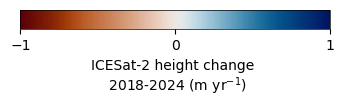

In [36]:

## Run the plot functions ##

print('Generating map...', end='', flush=True)
fig = make_map(h_plot, dpi=100, vlims=[-1, 1], rolling=50, save=True, transparent=True)
print('DONE')

print('Generating ensemble figs...', end='', flush=True)
#fig_list = make_ensemble_figs(save=True)
print('DONE')
